In [1]:
%reset -f
import tensorflow as tf
from importlib import reload
sess = tf.InteractiveSession()
import os
import random
from params import * 
import world 
from copy import copy
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
from network import * 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors as clrs
import time
%matplotlib inline

/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:

#Precision at what the goal state will be accepted. For more info look at my_world.game_over()
precision = 3

world = reload(world)
my_world = world.world(game_mode='constant_reward',goal_reward = 100,precision= precision)

In [4]:
num_actions=4
dqn_args   = {"n_out_h1" : 16, "kernel_size_h1":(8,8), "strides_h1" : 4, "padding" : "SAME", \
              "actvt_fct" : tf.nn.relu, "n_out_h2" : 32, "kernel_size_h2":(4,4), "strides_h2" : 2, \
              "n_out_h3" : 128,"initializer" : tf.contrib.layers.variance_scaling_initializer() }
num_targets = 3
targets = [{"vaxis" : vaxis, "haxis" : haxis} for vaxis,haxis in \
           zip(np.linspace(5,25,num_targets),np.linspace(5,25,num_targets))]



In [7]:
learner_out  , learner_vars,_   = network("learner"  ,**dqn_args,num_actions = num_actions, num_targets = num_targets)
predictor_out, predictor_vars,dense_layer = network("predictor",**dqn_args,num_actions = num_actions, num_targets = num_targets)

In [8]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [45]:
save_path = "one-ellipse/"


In [46]:
game_length = 0
play_game_length_over_t = []
play_time = []
range_x  = int(FRAME_DIM/2-MARGIN/2)
range_y  = int(FRAME_DIM/2-MARGIN/2)
parameter_space = np.array([(haxis,vaxis) for haxis in np.arange(1,range_x+1)\
                                          for vaxis in np.arange(1,range_y+1)])

max_qs_per_target     = [np.zeros((range_x+1,range_y+1)) for _ in range(len(targets))]
reward_per_target     = [np.zeros((range_x+1,range_y+1)) for _ in range(len(targets))]
all_qs_per_target     = [np.zeros((range_x+1,range_y+1,num_actions)) for _ in range(len(targets))]
last_layer_activation = np.zeros((range_x+1,range_y+1,128)) 

In [47]:
my_world.restart()

with tf.Session() as sess:

    if os.path.isfile(save_path+".index"):
        saver.restore(sess, save_path)


        for ellipse in parameter_space:
            my_world.haxis = ellipse[0]
            my_world.vaxis = ellipse[1]

            my_world.set_frame(which="first")

            state = my_world.get_frame()


            for idx in range(len(targets)):
                q_values = predictor_out[idx].eval(feed_dict={x: [state]})
                #q_values  = predictor_out[idx].eval(feed_dict={x:[state]})
                
                max_q = np.max(q_values)
                all_qs_per_target[idx][ellipse[0]][ellipse[1]] = q_values
                #reward_per_target[idx][ellipse[0]][ellipse[1]] = my_world.get_reward()
                max_qs_per_target[idx][ellipse[0]][ellipse[1]] = max_q
            
                #last_layer_activation[ellipse[0]][ellipse[1]] = dense_layer.eval(feed_dict={x: [state]})


INFO:tensorflow:Restoring parameters from one-ellipse/


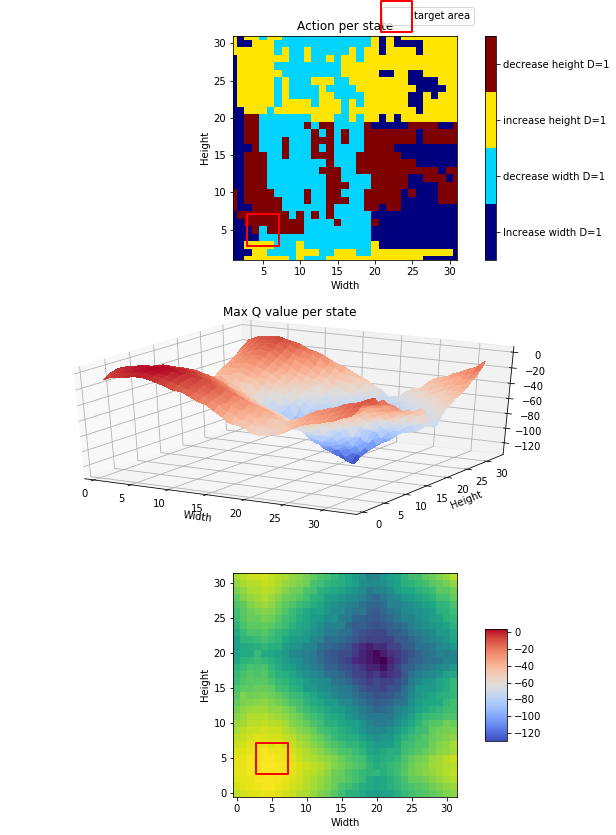

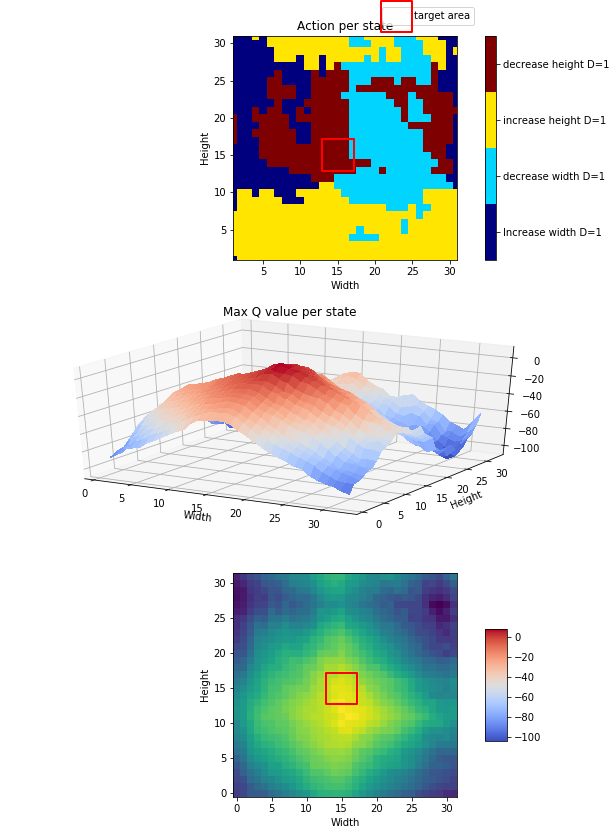

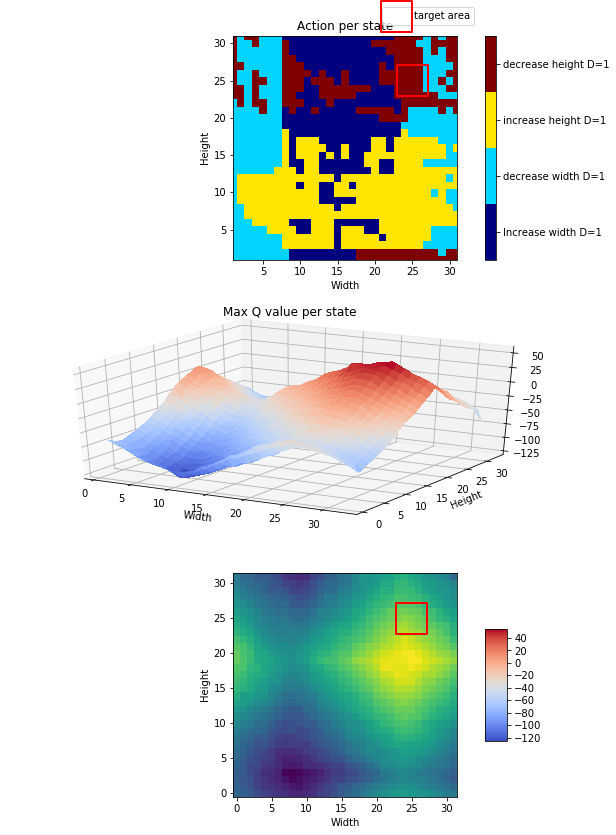

In [48]:
for current_target in range(len(targets)):
    fig = plt.figure(figsize=(10,14))

    ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312,projection="3d")
    ax3 = fig.add_subplot(313)
    cmap=plt.cm.jet

    norm = clrs.BoundaryNorm(np.arange(-.5,num_actions+.5), cmap.N)

    im = ax1.imshow(np.argmax(all_qs_per_target[current_target][1:,1:],axis=2),norm=norm,cmap=cmap,origin="lower")
    ax1.set_title("Action per state")
    ax1.set_xlim(1,range_x-1)
    ax1.set_ylim(1,range_y-1)
    ax1.set_xlabel("Width")
    ax1.set_ylabel("Height")
    cbar = fig.colorbar(im,ticks=np.arange(num_actions),spacing="uniform",ax=ax1)

    #ax1.vlines(targets[current_target]["vaxis"],0,range_x,color="red",label="target")

    #TODO instead of scatter use vlines and hlines
    ax1.scatter(targets[current_target]["haxis"],targets[current_target]["vaxis"],\
                color="red",label="target area",marker="s",s=1000,facecolors='none', edgecolors='r',lw=2)
    ax3.scatter(targets[current_target]["haxis"],targets[current_target]["vaxis"],\
                color="red",label="target area",marker="s",s=1000,facecolors='none', edgecolors='r',lw=2)
    ax1.legend(bbox_to_anchor=[1.1,1.15])
    cbar.ax.set_yticklabels(['Increase width D=1', 'decrease width D=1',\
                             'increase height D=1','decrease height D=1',\
                            'Increase width D=2', 'decrease width D=2',\
                             'increase height D=2','decrease height D=2']);


    X = np.arange(1, range_x+1)
    Y = np.arange(1, range_y+1)
    X, Y = np.meshgrid(X, Y)


    surf = ax2.plot_surface(X, Y, max_qs_per_target[current_target][1:,1:], rstride=1, cstride=1, cmap=cm.coolwarm,
            linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax2.set_ylabel("Height")
    ax2.set_xlabel("Width")
    ax2.set_title("Max Q value per state")
    
    ax3.imshow(max_qs_per_target[current_target][1:,1:],origin="lower")
    ax3.set_ylabel("Height")
    ax3.set_xlabel("Width")
    
    

    plt.show()

In [21]:
my_world.set_target(**targets[0])
range_x  = int(FRAME_DIM/2-MARGIN/2)
range_y  = int(FRAME_DIM/2-MARGIN/2)
parameter_space = np.array([(haxis,vaxis) for haxis in np.arange(1,range_x+1)\
                                          for vaxis in np.arange(1,range_y+1)])

reward_per_target     = [np.zeros((range_x+1,range_y+1)) for _ in range(len(targets))]

for ellipse in parameter_space:
    my_world.haxis = ellipse[0]
    my_world.vaxis = ellipse[1]

    my_world.set_frame(which="first")


    for idx in range(len(targets)):
       
        reward_per_target[idx][ellipse[0]][ellipse[1]] = my_world.get_reward()
     

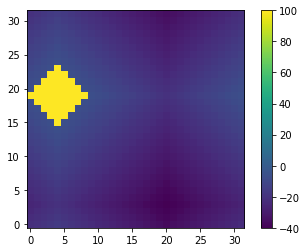

In [27]:
  
plt.imshow((reward_per_target[0][1:,1:]),origin="lower")
plt.colorbar()